In [ ]:
# Import statements
import subprocess
import os
import json

import pandas as pd
import statsmodels.api as sm

from IPython.display import display, Image, Markdown

In [2]:
# Hardset vars
dataset_path = "data/processed/labeled_asset_dataset_enriched.csv"
config_path = "config/generation_params.json"
alt_config = "config/alt_scenario_generation_params.json"

In [3]:
# Utility functions for running the MLflow pipeline, resetting it, and displaying results
def reset_pipeline():
    """Reset the pipeline by running the reset_pipeline.py script."""
    result = subprocess.run(
        ["python", "scripts/reset_pipeline.py"],
        capture_output=True,
        text=True,
        encoding="utf-8",
        errors="replace"  # prevent crashes from non-UTF-8 characters
    )

    print(result.stdout)
    if result.stderr:
        print(result.stderr)


def display_config(config_path):
    """Load and display the contents of a configuration file as formatted JSON."""
    if not os.path.exists(config_path):
        print(f"⚠️ Config file not found: {config_path}")
        return

    with open(config_path, "r") as f:
        params = json.load(f)

    display(Markdown(f"### Contents of `{config_path}`:"))
    display(Markdown(f"```json\n{json.dumps(params, indent=4)}\n```"))


def run_pipeline(dataset_path, alt_config=None, steps=None):
    """
    Run the MLflow pipeline fully or step-by-step.
    
    Args:
        dataset_path (str): Path to the dataset CSV.
        alt_config (str, optional): Alternate config file for the generate step.
        steps (list, optional): Specific pipeline steps to run. 
                                If None, runs the full pipeline entry point.
    """
    # Determine processed_dir based on dataset_path
    processed_dir = os.path.dirname(dataset_path)

    # Ensure processed_dir exists
    os.makedirs(processed_dir, exist_ok=True)

    # If dataset exists and no steps were specified, just load the data
    if steps is None:
        try:
            df = pd.read_csv(dataset_path)
            print("✅ Dataset loaded.")
            return df
        except FileNotFoundError:
            print(f"⚠️ {dataset_path} not found. Running full MLflow pipeline...")
            result = subprocess.run(
                [
                    "mlflow", "run", ".", "-e", "pipeline", "--env-manager=local",
                    "-P", f"processed_dir={processed_dir}"
                ],
                capture_output=True, text=True, encoding="utf-8", errors="replace"
            )
            print(result.stdout)
            if result.returncode != 0:
                print("❌ Full MLflow pipeline failed.")
                raise RuntimeError("Pipeline execution failed.")
            if os.path.exists(dataset_path):
                print("✅ Dataset generated and loaded.")
                return pd.read_csv(dataset_path)
            else:
                raise FileNotFoundError(f"Dataset still not found at {dataset_path} after pipeline run.")
    else:
        # Step-by-step pipeline execution
        step_cmds = []
        for step in steps:
            if step == "generate":
                cmd = [
                    "mlflow", "run", ".", "-e", "generate", "--env-manager=local"
                ]
                if alt_config:
                    cmd.extend(["-P", f"config={alt_config}"])
                step_cmds.append(("Generate", cmd))
            elif step == "prepare":
                cmd = [
                    "mlflow", "run", ".", "-e", "prepare", "--env-manager=local",
                    "-P", f"processed_dir={processed_dir}"
                ]
                step_cmds.append(("Prepare", cmd))
            elif step == "train-both":
                step_cmds.append(("Train Both", ["mlflow", "run", ".", "-e", "train-both", "--env-manager=local"]))
            else:
                print(f"⚠️ Unknown step: {step}")

        for name, cmd in step_cmds:
            print(f"\n--- Running: {name} ---\n{' '.join(cmd)}\n")
            result = subprocess.run(cmd, capture_output=True, text=True, encoding="utf-8", errors="replace")
            print(result.stdout)
            if result.returncode != 0:
                print(f"❌ Step '{name}' failed. Check the output above.")
                break
            else:
                print(f"✅ Step '{name}' completed.\n")

        # Reload dataset after step execution if it exists
        if os.path.exists(dataset_path):
            return pd.read_csv(dataset_path)
        else:
            print("⚠️ Dataset not found after pipeline steps.")
            return None


def calculate_presence_stats(df):
    """Calculate asset presence counts and percentages across Inventory and IPAM."""
    total_assets = len(df)
    present_inventory = (df["missing_in_inventory"] == 0).sum()
    present_ipam = (df["missing_in_ipam"] == 0).sum()
    present_all = ((df["missing_in_inventory"] == 0) & (df["missing_in_ipam"] == 0)).sum()

    return {
        "total_assets": total_assets,
        "present_inventory": present_inventory,
        "pct_inventory": present_inventory / total_assets * 100,
        "present_ipam": present_ipam,
        "pct_ipam": present_ipam / total_assets * 100,
        "present_all": present_all,
        "pct_all": present_all / total_assets * 100
    }


def display_presence_summary(stats, scenario_name):
    """Display a quick summary of asset presence counts and percentages."""
    print(f"\n=== {scenario_name} Presence Summary ===")
    print(f"Total Observability Assets: {stats['total_assets']:,}")
    print(f"Present in Inventory: {stats['present_inventory']:,} ({stats['pct_inventory']:.1f}%)")
    print(f"Present in IPAM: {stats['present_ipam']:,} ({stats['pct_ipam']:.1f}%)")
    print(f"Present in BOTH: {stats['present_all']:,} ({stats['pct_all']:.1f}%)")

    summary = pd.DataFrame({
        "Metric": ["Present in Inventory", "Present in IPAM", "Present in BOTH"],
        "Count": [stats["present_inventory"], stats["present_ipam"], stats["present_all"]],
        "Percent": [stats["pct_inventory"], stats["pct_ipam"], stats["pct_all"]]
    })
    display(summary)


def run_completeness_test(present_both, total_assets, threshold=0.75, alpha=0.05):
    stat, p_value = sm.stats.proportions_ztest(
        count=present_both,
        nobs=total_assets,
        value=threshold,
        alternative="larger"
    )
    return stat, p_value, p_value <= alpha

    
def evaluate_completeness(stats, scenario_name):
    """Run and display the completeness statistical test in a clean format."""
    z_stat, p_value, significant = run_completeness_test(stats["present_all"], stats["total_assets"])
    result_text = "✅ Reject H₀ – completeness is statistically significant." if significant else "❌ Fail to reject H₀ – completeness is not statistically significant."

    display(Markdown(f"""
### Completeness Statistical Test ({scenario_name})

| Metric               | Value                |
|----------------------|----------------------|
| Null Hypothesis (H₀) | Completeness ≤ 75%   |
| Alternative (H₁)     | Completeness > 75%   |
| Observed Rate        | {stats['pct_all']:.2f}% |
| Z-statistic          | {z_stat:.4f}        |
| P-value              | {p_value:.4e}       |
| Alpha (α)            | 0.05               |
| Result               | {result_text}       |
"""))


# define a function to evaluate model performance
def evaluate_model(report_path, model_name, benchmark_f1=0.80):
    """Evaluate model performance against the success benchmark."""
    if not os.path.exists(report_path):
        return {
            "model": model_name,
            "f1_score": None,
            "accuracy": None,
            "result": f"⚠️ No report found for {model_name}"
        }
    
    with open(report_path, "r") as f:
        report = json.load(f)
    
    f1_score = report["weighted avg"]["f1-score"]
    accuracy = report["accuracy"]
    result = "✅ Meets benchmark" if f1_score >= benchmark_f1 else "❌ Below benchmark"
    
    return {
        "model": model_name,
        "f1_score": f1_score,
        "accuracy": accuracy,
        "result": result
    }
    

def format_metric(value, percent=False):
    """Safely format metrics for display."""
    if value is None:
        return "N/A"
    return f"{value:.2%}" if percent else f"{value:.2f}"


def evaluate_models(inventory_report, ipam_report, scenario_name=None):
    """Evaluate and display predictive model performance in a clean table format."""
    inventory_eval = evaluate_model(inventory_report, "Inventory Model")
    ipam_eval = evaluate_model(ipam_report, "IPAM Model")

    scenario_title = f" ({scenario_name})" if scenario_name else ""

    display(Markdown(f"""
### Predictive Model Evaluation{scenario_title}

| Model            | Accuracy | Weighted F1-Score | Result            |
|------------------|----------|-------------------|-------------------|
| {inventory_eval['model']} | {format_metric(inventory_eval['accuracy'], percent=True)} | {format_metric(inventory_eval['f1_score'])} | {inventory_eval['result']} |
| {ipam_eval['model']}      | {format_metric(ipam_eval['accuracy'], percent=True)} | {format_metric(ipam_eval['f1_score'])} | {ipam_eval['result']} |

**Benchmark:** F1-Score ≥ 0.80 required for success.
"""))


def display_report_images(scenario_name):
    """Display generated report images from the pipeline."""
    reports_dir = "reports"
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif')
    found_images = []

    for root, _, files in os.walk(reports_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                found_images.append(os.path.join(root, file))

    if found_images:
        display(Markdown(f"### Generated Report Images ({scenario_name})"))
        for img_path in found_images:
            rel_path = os.path.relpath(img_path, reports_dir)
            display(Markdown(f"**{rel_path}**"))
            display(Image(filename=img_path))
    else:
        print(f"No report images found in '{reports_dir}' for {scenario_name}.")


def display_conclusion(stats, scenario_name, completeness_significant, inventory_eval, ipam_eval, key_features=None):
    """Generate and display a comprehensive conclusion summary for a scenario."""
    meets_threshold = stats['pct_all'] >= 75
    threshold_text = "meets" if meets_threshold else "does not meet"
    significance_text = (
        "is statistically significant" if completeness_significant else "is not statistically significant"
    )

    inv_model_text = "met" if inventory_eval["f1_score"] and inventory_eval["f1_score"] >= 0.80 else "did not meet"
    ipam_model_text = "met" if ipam_eval["f1_score"] and ipam_eval["f1_score"] >= 0.80 else "did not meet"

    conclusion_md = f"""
## Conclusion ({scenario_name})

The analysis confirms that the original asset presence rate across systems **{threshold_text}** the 75% threshold and {significance_text} based on the statistical test.

Out of **{stats['total_assets']:,}** observability assets:
- **{stats['present_inventory']:,}** ({stats['pct_inventory']:.1f}%) were found in the Inventory system.
- **{stats['present_ipam']:,}** ({stats['pct_ipam']:.1f}%) were found in IPAM.
- **{stats['present_all']:,}** ({stats['pct_all']:.1f}%) were present in both systems.

Model performance evaluation:
- The Inventory model **{inv_model_text}** the benchmark (F1 ≥ 0.80).
- The IPAM model **{ipam_model_text}** the benchmark (F1 ≥ 0.80).

"""
    if key_features:
        conclusion_md += f"Key features driving missingness include: **{', '.join(key_features)}**.\n\n"

    conclusion_md += """Beyond validating data completeness, these insights enable the organization to focus audit efforts 
on specific processes, automation, or staff actions most likely to cause data gaps. 
This data-driven approach not only supports immediate project goals but also lays the groundwork for 
long-term improvements in asset data quality and system reliability.
"""
    display(Markdown(conclusion_md))

In [4]:
# Reset the pipeline (cleans data, mlruns, models, reports)
reset_pipeline()

🔄 Cleaning up pipeline artifacts...
🧹 Removed directory: data
🧹 Removed directory: mlruns
🧹 Removed directory: models
🧹 Removed directory: reports
⚠️ Directory not found: __pycache__
✅ Cleanup complete.



In [5]:
display_config(config_path)

### Contents of `config/generation_params.json`:

```json
{
    "IPAM_REGION_MISSING_PROBS": {
        "northeast": 0.3,
        "northwest": 0.01,
        "central": 0.01,
        "east": 0.02,
        "west": 0.05,
        "southeast": 0.03,
        "southwest": 0.01
    },
    "INVENTORY_MODEL_MISSING_PROBS": {
        "ISR4431": 0.5,
        "SRX345": 0.6,
        "ETX-2": 0.4,
        "MX204": 0.01,
        "NCS540": 0.05,
        "7750 SR-1": 0.01,
        "7280R": 0.03,
        "FSP3000": 0.1,
        "FSP150": 0.1,
        "QFX5120": 0.05,
        "7050X3": 0.02,
        "Catalyst9300": 0.03
    },
    "DEFAULT_MODEL_FAILURE_PROB": 0.1,
    "DEFAULT_REGION_FAILURE_PROB": 0.1
}
```

In [6]:
# Load the dataset for analysis, if it is not present, trigger a mlflow run using the default pipeline settings
df = run_pipeline(dataset_path)

⚠️ data/processed/labeled_asset_dataset_enriched.csv not found. Running full MLflow pipeline...
[DEBUG] Pipeline received config: config/generation_params.json
✅ Enriched dataset written to: data/processed\labeled_asset_dataset_enriched.csv
--- Model Report ---
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1966
           1       0.59      0.32      0.41       284

    accuracy                           0.89      2250
   macro avg       0.75      0.64      0.67      2250
weighted avg       0.87      0.89      0.87      2250

--- Model Report ---
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2103
           1       0.00      0.00      0.00       147

    accuracy                           0.93      2250
   macro avg       0.47      0.50      0.48      2250
weighted avg       0.87      0.93      0.90      2250


✅ Dataset generated and loaded.


In [7]:
# Default scenario stats
default_stats = calculate_presence_stats(df)

In [8]:
display_presence_summary(default_stats, "Default Scenario")


=== Default Scenario Presence Summary ===
Total Observability Assets: 11,246
Present in Inventory: 9,826 (87.4%)
Present in IPAM: 10,512 (93.5%)
Present in BOTH: 9,171 (81.5%)


,Metric,Count,Percent
0,Present in Inventory,9826,87.373288
1,Present in IPAM,10512,93.473235
2,Present in BOTH,9171,81.548995


In [9]:
evaluate_completeness(default_stats, "Default Scenario")


### Completeness Statistical Test (Default Scenario)

| Metric               | Value                |
|----------------------|----------------------|
| Null Hypothesis (H₀) | Completeness ≤ 75%   |
| Alternative (H₁)     | Completeness > 75%   |
| Observed Rate        | 81.55% |
| Z-statistic          | 17.9042        |
| P-value              | 5.4699e-72       |
| Alpha (α)            | 0.05               |
| Result               | ✅ Reject H₀ – completeness is statistically significant.       |


In [10]:
# Save significance result for use in conclusion
_, _, default_completeness_significant = run_completeness_test(
    default_stats["present_all"], default_stats["total_assets"]
)

In [11]:
# Evaluate models
inventory_eval = evaluate_model("reports/inventory/inventory_classification_report.json", "Inventory Model")
ipam_eval = evaluate_model("reports/ipam/ipam_classification_report.json", "IPAM Model")

evaluate_models("reports/inventory/inventory_classification_report.json",
                "reports/ipam/ipam_classification_report.json",
                "Default Scenario")


### Predictive Model Evaluation (Default Scenario)

| Model            | Accuracy | Weighted F1-Score | Result            |
|------------------|----------|-------------------|-------------------|
| Inventory Model | 88.58% | 0.87 | ✅ Meets benchmark |
| IPAM Model      | 93.16% | 0.90 | ✅ Meets benchmark |

**Benchmark:** F1-Score ≥ 0.80 required for success.


### Generated Report Images (Default Scenario)

**inventory\inventory_feature_importance.png**

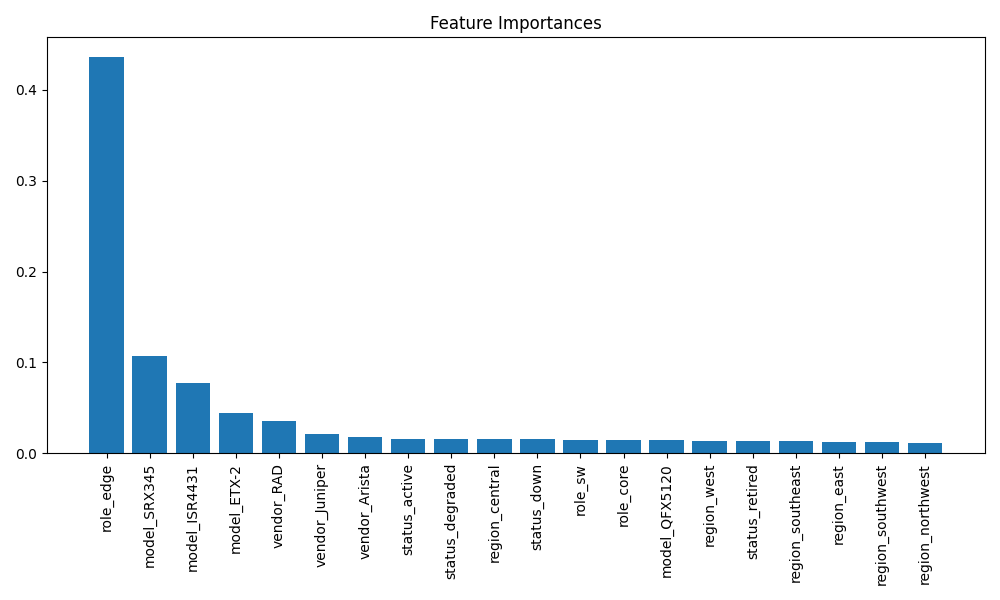

**ipam\ipam_feature_importance.png**

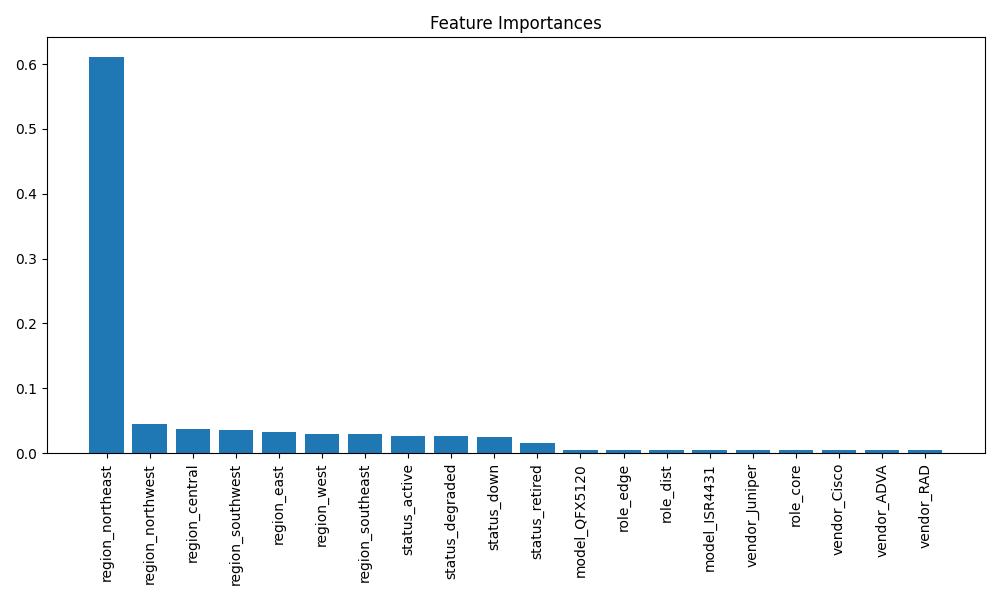

In [12]:
display_report_images("Default Scenario")

# Conclusion

In [23]:
display_conclusion(
    default_stats,
    "Default Scenario",
    completeness_significant=default_completeness_significant,
    inventory_eval=inventory_eval,
    ipam_eval=ipam_eval,
    key_features=["region", "role"]
)


## Conclusion (Default Scenario)

The analysis confirms that the original asset presence rate across systems **meets** the 75% threshold and is statistically significant based on the statistical test.

Out of **11,246** observability assets:
- **9,821** (87.3%) were found in the Inventory system.
- **10,515** (93.5%) were found in IPAM.
- **9,178** (81.6%) were present in both systems.

Model performance evaluation:
- The Inventory model **met** the benchmark (F1 ≥ 0.80).
- The IPAM model **met** the benchmark (F1 ≥ 0.80).

Key features driving missingness include: **region, role**.

Beyond validating data completeness, these insights enable the organization to focus audit efforts 
on specific processes, automation, or staff actions most likely to cause data gaps. 
This data-driven approach not only supports immediate project goals but also lays the groundwork for 
long-term improvements in asset data quality and system reliability.


# Analysis demonstrating alternative data generation scenarios

To validate that our ML model would make different predictions given different failures, we ran an alternative config to validate

In [14]:
# display_config(alt_config)
display_config(alt_config)

### Contents of `config/alt_scenario_generation_params.json`:

```json
{
    "IPAM_REGION_MISSING_PROBS": {
        "northeast": 0.01,
        "northwest": 0.01,
        "central": 0.01,
        "east": 0.02,
        "west": 0.45,
        "southeast": 0.03,
        "southwest": 0.01
    },
    "INVENTORY_MODEL_MISSING_PROBS": {
        "ISR4431": 0.01,
        "SRX345": 0.03,
        "ETX-2": 0.02,
        "MX204": 0.01,
        "NCS540": 0.05,
        "7750 SR-1": 0.01,
        "7280R": 0.03,
        "FSP3000": 0.1,
        "FSP150": 0.87,
        "QFX5120": 0.91,
        "7050X3": 0.02,
        "Catalyst9300": 0.03
    },
    "DEFAULT_MODEL_FAILURE_PROB": 0.1,
    "DEFAULT_REGION_FAILURE_PROB": 0.1
}
```

In [16]:
# Run the pipeline for the alternative scenario
alt_df = run_pipeline(
    dataset_path="data/processed/labeled_asset_dataset_enriched.csv",
    alt_config="config/alt_scenario_generation_params.json",
    steps=["generate", "prepare", "train-both"]
)


--- Running: Generate ---
mlflow run . -e generate --env-manager=local -P config=config/alt_scenario_generation_params.json




✅ Step 'Generate' completed.


--- Running: Prepare ---
mlflow run . -e prepare --env-manager=local -P processed_dir=data/processed

✅ Enriched dataset written to: data/processed\labeled_asset_dataset_enriched.csv

✅ Step 'Prepare' completed.


--- Running: Train Both ---
mlflow run . -e train-both --env-manager=local

--- Model Report ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1830
           1       0.88      0.88      0.88       420

    accuracy                           0.96      2250
   macro avg       0.93      0.93      0.93      2250
weighted avg       0.96      0.96      0.96      2250

--- Model Report ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2066
           1       0.41      0.16      0.23       184

    accuracy                           0.91      2250
   macro avg       0.67      0.57      0.59      2250
weighted avg       0.89      0.91    

In [17]:
# Calculate presence statistics
alt_stats = calculate_presence_stats(alt_df)

In [18]:
# Display quick summary
display_presence_summary(alt_stats, "Alternative Scenario")


=== Alternative Scenario Presence Summary ===
Total Observability Assets: 11,246
Present in Inventory: 9,148 (81.3%)
Present in IPAM: 10,327 (91.8%)
Present in BOTH: 8,395 (74.6%)


,Metric,Count,Percent
0,Present in Inventory,9148,81.344478
1,Present in IPAM,10327,91.828206
2,Present in BOTH,8395,74.648764


In [19]:
# Evaluate completeness (statistical test)
evaluate_completeness(alt_stats, "Alternative Scenario")


### Completeness Statistical Test (Alternative Scenario)

| Metric               | Value                |
|----------------------|----------------------|
| Null Hypothesis (H₀) | Completeness ≤ 75%   |
| Alternative (H₁)     | Completeness > 75%   |
| Observed Rate        | 74.65% |
| Z-statistic          | -0.8562        |
| P-value              | 8.0406e-01       |
| Alpha (α)            | 0.05               |
| Result               | ❌ Fail to reject H₀ – completeness is not statistically significant.       |


In [20]:
# Save significance result for use in conclusion
_, _, alt_completeness_significant = run_completeness_test(
    alt_stats["present_all"],
    alt_stats["total_assets"]
)

In [21]:
# Evaluate models
inventory_eval_alt = evaluate_model("reports/inventory/inventory_classification_report.json", "Inventory Model")
ipam_eval_alt = evaluate_model("reports/ipam/ipam_classification_report.json", "IPAM Model")


evaluate_models(
    "reports/inventory/inventory_classification_report.json",
    "reports/ipam/ipam_classification_report.json",
    "Alternative Scenario"
)


### Predictive Model Evaluation (Alternative Scenario)

| Model            | Accuracy | Weighted F1-Score | Result            |
|------------------|----------|-------------------|-------------------|
| Inventory Model | 95.56% | 0.96 | ✅ Meets benchmark |
| IPAM Model      | 91.24% | 0.89 | ✅ Meets benchmark |

**Benchmark:** F1-Score ≥ 0.80 required for success.


### Generated Report Images (Alternative Scenario)

**inventory\inventory_feature_importance.png**

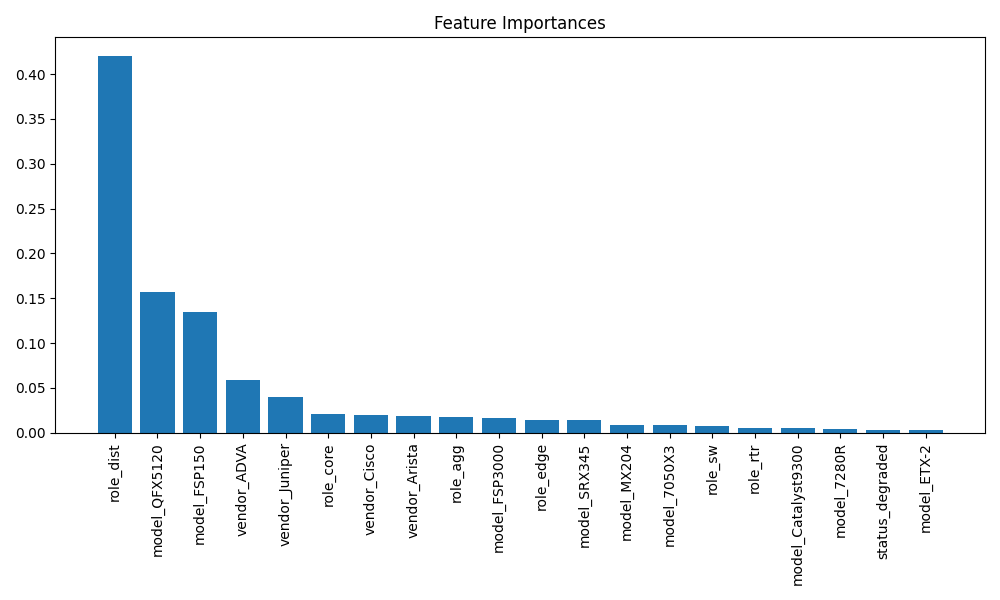

**ipam\ipam_feature_importance.png**

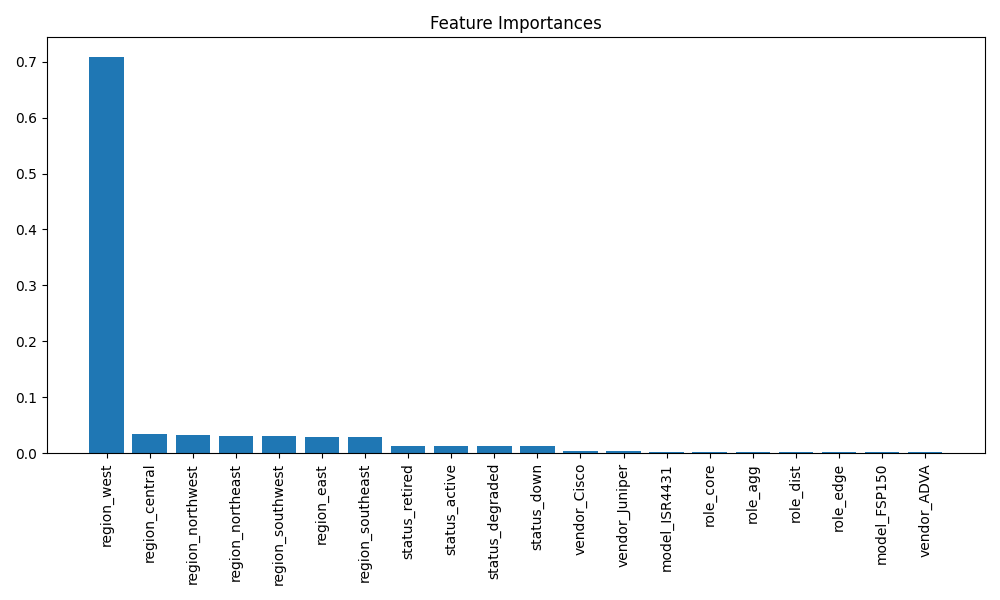

In [22]:
# Display generated report images
display_report_images("Alternative Scenario")

In [24]:
# Display conclusion for alternative scenario
display_conclusion(
    alt_stats,
    "Alternative Scenario",
    completeness_significant=alt_completeness_significant,
    inventory_eval=inventory_eval_alt,
    ipam_eval=ipam_eval_alt,
    key_features=["region", "role"] 
)


## Conclusion (Alternative Scenario)

The analysis confirms that the original asset presence rate across systems **does not meet** the 75% threshold and is not statistically significant based on the statistical test.

Out of **11,246** observability assets:
- **9,139** (81.3%) were found in the Inventory system.
- **10,325** (91.8%) were found in IPAM.
- **8,387** (74.6%) were present in both systems.

Model performance evaluation:
- The Inventory model **met** the benchmark (F1 ≥ 0.80).
- The IPAM model **met** the benchmark (F1 ≥ 0.80).

Key features driving missingness include: **region, role**.

Beyond validating data completeness, these insights enable the organization to focus audit efforts 
on specific processes, automation, or staff actions most likely to cause data gaps. 
This data-driven approach not only supports immediate project goals but also lays the groundwork for 
long-term improvements in asset data quality and system reliability.
